<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "4F"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/4F/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


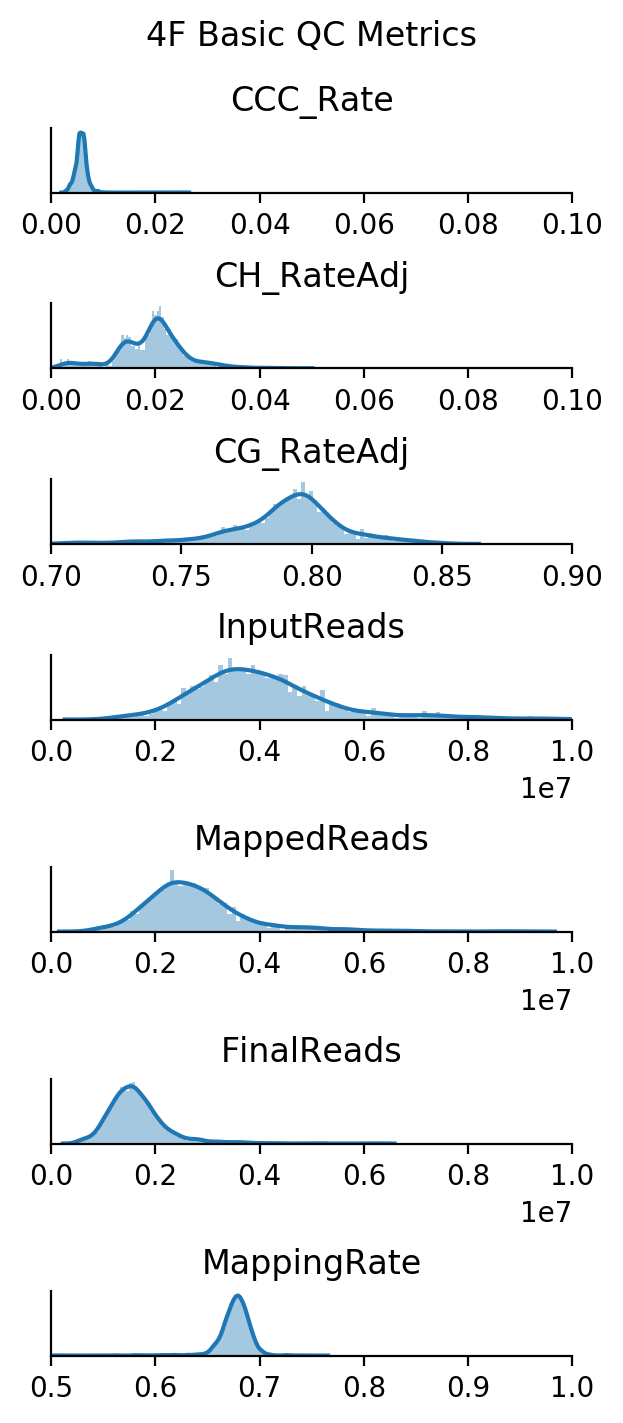

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

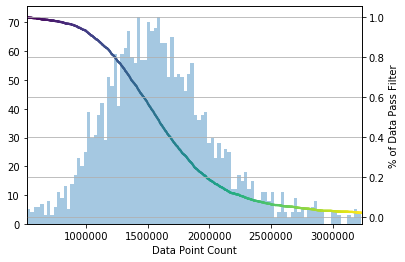

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2555/2555 (100.0%)
CG_RateAdj passed 2555/2555 (100.0%)
CH_RateAdj passed 2555/2555 (100.0%)
FinalReads passed 2555/2555 (100.0%)
MappingRate passed 2555/2555 (100.0%)
Overall passed 2555/2555 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180329 1315
180402 1240


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 317 82.6%
ad002 331 86.2%
ad004 320 83.3%
ad006 323 84.1%
ad007 315 82.0%
ad008 326 84.9%
ad010 319 83.1%
ad012 304 79.2%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
4F_M_0,/gale/raidix/rdx-4/CEMBA_RS1/4F/CEMBA180329_4F...,0.00499,0.80480,0.80382,0.01851,0.01359,1239380.0,2914476,1862956.0,4F,...,3.757441,-19.280878,23.758370,8.186080,D1L-Fstl4 Sipa1l2,5.188559,3.205159,16.546885,-2.134921,True
4F_M_1,/gale/raidix/rdx-4/CEMBA_RS1/4F/CEMBA180329_4F...,0.00530,0.80256,0.80151,0.01875,0.01352,1072817.0,2476780,1613182.0,4F,...,3.784016,-20.178196,29.274635,4.990765,D1L-Fstl4 Sipa1l2,3.531378,4.236072,24.048682,4.301776,True
4F_M_10,/gale/raidix/rdx-4/CEMBA_RS1/4F/CEMBA180329_4F...,0.00588,0.77066,0.76930,0.02435,0.01858,1909670.0,4513716,3078518.0,4F,...,3.468466,-8.251703,-18.022435,8.557903,IT-L23 Ptprt,-1.944946,1.389210,-15.278399,18.103648,True
4F_M_100,/gale/raidix/rdx-4/CEMBA_RS1/4F/CEMBA180329_4F...,0.00697,0.79882,0.79741,0.03202,0.02523,1601531.0,3729706,2544442.0,4F,...,7.565756,0.878169,13.085071,-23.898931,EP Tspan5,2.832633,-2.268515,5.953999,1.537250,True
4F_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/4F/CEMBA180329_4F...,0.00604,0.78794,0.78665,0.02496,0.01903,2119171.0,4875690,3334183.0,4F,...,-6.978913,6.839964,35.549193,-2.130442,OLF-Exc Sgcd,-7.247796,0.615745,16.071636,41.998845,True
4F_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/4F/CEMBA180329_4F...,0.00718,0.78100,0.77942,0.03258,0.02558,1700471.0,3852684,2671203.0,4F,...,2.772051,5.201594,25.596347,-30.575370,OLF-Exc Cdh9,8.148616,-11.840764,-28.614014,-25.677489,True
4F_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/4F/CEMBA180329_4F...,0.00674,0.79913,0.79777,0.02925,0.02266,2026408.0,4656664,3226815.0,4F,...,1.945893,7.673748,14.716530,-34.751900,OLF-Exc Cux2,4.392415,-10.814408,-15.067605,-5.358312,True
4F_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/4F/CEMBA180329_4F...,0.00655,0.80069,0.79938,0.02836,0.02195,2025389.0,4665758,3213727.0,4F,...,7.677722,0.948181,13.339670,-24.368896,EP Tspan5,2.647671,-2.578020,5.790406,2.182196,True
4F_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/4F/CEMBA180329_4F...,0.00694,0.78051,0.77898,0.03162,0.02485,1830956.0,4379176,2978262.0,4F,...,2.602164,6.489749,20.239442,-30.704336,OLF-Exc Cdh9,4.826548,-13.882101,-34.690633,-17.791080,True
4F_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/4F/CEMBA180329_4F...,0.00606,0.78028,0.77894,0.02519,0.01925,1835874.0,4463784,3038329.0,4F,...,1.709340,6.335423,27.142486,-38.274398,OLF-Exc Bmpr1b,7.194248,-8.363898,4.520257,-15.542799,True
